In [1]:
"""

RUN THIS IN THE run_algos/classifier directory

this file takes explores logistic regression models.

Potential IDEA: combined/joined df of recall and adverse events and creates a model to predict the likelihood
of an adverse event, and if so, which type. 


pip install scikit-learn nltk matplotlib cleanco levenshtein name_matching xgboost pyspark

"""

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import unicodedata
from cleanco import basename
import time
import Levenshtein
from name_matching.name_matcher import NameMatcher
import pickle
import os
import psycopg2


nltk.download('stopwords')
nltk.download('punkt_tab')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prpar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\prpar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# get data from db. we want this to emulate reading real-time data

# PREREQ: in terminal, import the data with the following command:
# $ zstd --stdout -d pg-slim.zst | psql --dbname=[name] -U [user]
# OR run import_postgres_dump()

def import_postgres_dump(dump_file_path='../pg-slim', ):
    try:
        DB_PARAMS = {
            "host": "localhost",
            "database": "openfda_slim",
            "user": "postgres",
            "password": os.environ.get("postgres_password"),
            "port": 5432
        }
        conn = psycopg2.connect(**DB_PARAMS)
        conn.autocommit = True
        cursor = conn.cursor()
        # read the dump file
        with open(dump_file_path, 'r') as f:
            sql = f.read()
            
        # execute file contentsL
        cursor.execute(sql)
        
        print("Dump imported successfully")
        
    except Exception as e:
        print(f"Error importing dump: {e}")    


def read_table(table,query=None):
    DB_PARAMS = {
        "host": "localhost",
        "database": "openfda_recalls",
        "user": "postgres",
        "password": os.environ.get("postgres_password"),
        "port": 5432
    }
    def get_postgres_conn():
        conn = None
        try:
            conn = psycopg2.connect(**DB_PARAMS)
            return conn
        
        except psycopg2.Error as e:
            print(f"Database error: {e}")
            return pd.DataFrame()
    conn = get_postgres_conn()
    print(f'loading table: {table}....')
    if query is None:
        query = f'select * from {table}'
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df


In [3]:
# NOTE: i got a memory error even running this 

# start = time.time()
# import_postgres_dump() # only need to run once locally. this will take a while..
# print(f'runtime: {time.time()-start} seconds')

In [4]:
# get device event
df_device_event = read_table('device_event',
                             """
                             select distinct d.manufacturer_d_name, e.event_type, device_report_product_code, d.openfda_regulation_number, d.model_number, d.openfda_device_name
                             from device_event e join device d on d.event_id = e.event_id
                             """
                            )
# get classification
df_class = read_table('device_classification')

# get recall
df_recall = read_table('recall',
                      '''
                      select openfda_device_name, count(*) recall_count from recall group by openfda_device_name
                      '''
                      )


loading table: device_event....


C:\Users\prpar\AppData\Local\Temp\ipykernel_36356\3962781003.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


loading table: device_classification....
loading table: recall....


## basic procedure

FROM REPORT: 

Our response was a binary variable for whether or not the device
was recalled. Our initial predictors were the number
of times each device had been associated with a
particular event type, the FDA classification of the
device (represented as a series of binary features,
one for each device class), the regulation code of the
device (represented as a series of binary features,
one for each regulation code), whether the device
had undergone the pre-market approval process,
and whether the device had undergone the 510K
notification process. 

LOGISTIC REGRESSION: given a device event, predict the likelihood of a recall.

required data: 
- event_type (events)
- count (events)
- product code (classification)
- device name (classification)
- device classification (classification)
- regulation number (classification)
- pre-market approved? (classification) --> check submission_type_id = 2
- 510k process? (classification) --> submission_type_id = 1
- recall device name? (recall) --> check if join successful

In [5]:
def preprocess(df, col):
    """
    0. replace Nan with empty string
    1. lower and strip spaces
    2. remove non-ascii chars
    3. remove punctuation
    4. remove common legal business strings (like 'corp')
    """
    # remove NaN or None
    df = df.fillna('')
    
    stop_words = set(stopwords.words('english'))
    def f(x):
        x = x.lower().strip() # step 1
        x = unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode() # step 2
        x = re.sub(r'[^\w\s]', '', x) # step 3
        x = basename(x) # step 4
        return x
        
    return df[col].apply(lambda x: f(x))
    
    

## preprocess data

In [6]:
# preprocess names where applicable
df_device_event['prprc_manufacturer_d_name'] = preprocess(df_device_event, 'manufacturer_d_name')
df_device_event['prprc_event_device_name'] = preprocess(df_device_event, 'openfda_device_name')
df_class['prprc_class_device_name'] = preprocess(df_class, 'device_name')
df_recall['prprc_recall_device_name'] = preprocess(df_recall, 'openfda_device_name')

## join event with device classification on name

In [7]:
# join events with product code
df_merged = df_device_event.merge(df_class, left_on='prprc_event_device_name', right_on='prprc_class_device_name')

In [8]:
len(df_merged)

10480

In [9]:
# if submission_type_id = 1, then 510k approved
# if submission_type_id = 2, then PMA approved
# else, Other
df_merged['pma_approval'] = df_merged['submission_type_id'].apply(lambda x: 1 if x == '2' else 0)
df_merged['510k_approval'] = df_merged['submission_type_id'].apply(lambda x: 1 if x == '1' else 0)

## join with device recall 

In [10]:
df_merged = df_merged.merge(df_recall, left_on='prprc_event_device_name', right_on='prprc_recall_device_name', how='left')

In [11]:
len(df_merged)

10490

In [12]:
df_merged['recall_count'] = df_merged['recall_count'].fillna(0.0)

In [13]:
df_merged['recall'] = df_merged['recall_count'].apply(lambda x: 1 if x > 0.0 else 0)

In [14]:
df_merged['recall'].value_counts()

recall
1    9907
0     583
Name: count, dtype: int64

## group to get event counts

In [15]:
# group by and get counts -- removed manufacturer name because it adds unnecessary complexity 
event_counts = df_merged.groupby(['device_name', 'product_code', 'event_type', 'device_class', 'regulation_number', 'pma_approval', '510k_approval', 'recall']).size().reset_index(name='num_events')
# reorder columns
event_counts = event_counts[[
    'device_name',
    'product_code',
    # 'prprc_manufacturer_d_name',
    'event_type',
    'device_class',
    'regulation_number',
    'pma_approval',
    '510k_approval',
    'num_events',
    'recall' # output variable
]]

# drop empty device names
event_counts = event_counts[event_counts['device_name'] != '']
print('Result contains:', len(event_counts), 'rows\n')
event_counts.head(10)


Result contains: 1363 rows



,device_name,product_code,event_type,device_class,regulation_number,pma_approval,510k_approval,num_events,recall
0,"Absorbent, Carbon-Dioxide",CBL,Malfunction,1,868.5300,0,0,1,1
1,"Abutment, Implant, Dental, Endosseous",NHA,Injury,2,872.3630,0,1,6,1
2,"Abutment, Implant, Dental, Endosseous",NHA,Malfunction,2,872.3630,0,1,6,1
3,"Accelerator, Linear, Medical",IYE,Malfunction,2,892.5050,0,1,1,1
4,"Accessories, Arthroscopic",NBH,Malfunction,1,888.1100,0,0,11,1
5,"Accessories, Blood Circuit, Hemodialysis",KOC,Malfunction,2,876.5820,0,1,2,1
6,"Accessories, Catheter",KGZ,Malfunction,1,878.4200,0,0,2,1
7,"Accessories, Cleaning Brushes, For Endoscope",MNL,Malfunction,1,876.1500,0,0,4,1
8,"Accessories, Cleaning, For Endoscope",FEB,Malfunction,2,876.1500,0,1,10,1
9,"Accessories, Implant, Dental, Endosseous",NDP,Malfunction,1,872.3980,0,0,2,1


## train a model on given data


In [16]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA, SparsePCA


In [17]:
categorical = ['product_code', 'event_type', 'device_class', 'regulation_number']
numerical = ['pma_approval', '510k_approval', 'num_events']
# assume we only have one text col to vectorize 
text = 'device_name' # ['device_name', 'prprc_manufacturer_d_name']


In [31]:
def preprocess_data(df, categorical, text, numerical, pca=None, encoder=None, vectorizer=None):
    """
    given data df, convert
    - categorical columns to numerical
    - text to TFIDF 
    - nans in numerical cols (though at this point there shouldn't be)
    """
    ######################################
    cat_data = df[categorical]
    if encoder is None:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
        encoder.fit(cat_data)
    cat_data_encoded = encoder.transform(cat_data)
    
    ######################################
    # convert text data into numerical representation
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(df[text])
    text_data_vectorized = vectorizer.transform(df[text])
   
    # dimensionality reduction using pca and convert to df; tfidf returns sparse arrays
    if pca is None:
        # keep 500 cols
        pca = PCA(n_components=500)
        pca.fit(text_data_vectorized)
    text_data_pca = pd.DataFrame(pca.transform(text_data_vectorized))
    
    ######################################    
    # fill na for numerical
    numerical_data = df[numerical]
    for c in numerical:
        numerical_data[c] = pd.to_numeric(numerical_data[c], errors='coerce').fillna(0)
    
    ######################################
    # concat together
    concat_data = pd.concat([cat_data_encoded, text_data_pca, numerical_data], axis=1)
    print(concat_data.shape)

    return concat_data, encoder, vectorizer, pca




In [32]:
data, encoder, vectorizer, pca = preprocess_data(event_counts, categorical, text, numerical)


(1363, 2005)


C:\Users\prpar\AppData\Local\Temp\ipykernel_36356\4196008724.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_data[c] = pd.to_numeric(numerical_data[c], errors='coerce').fillna(0)


In [33]:
# split into X and y
X = data
y = event_counts.values[:, -1]
print('original shape: ', X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=62)
print('after split:\n')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



original shape:  (1363, 2005) (1363,)
after split:

(954, 2005) (954,)
(409, 2005) (409,)


### xgboost example

In [34]:
start = time.time()
model = xgb.XGBClassifier(n_estimators=50, random_state=62, objective='binary:logistic', eval_metric='logloss') 
model.fit(X_train, y_train)
print(f'----------- XGBoost runtime: {time.time() - start} seconds -----------')

----------- XGBoost runtime: 2.4688196182250977 seconds -----------


In [35]:
# predict on test set
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test.astype(int), predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 92.18%


In [ ]:
# emulate getting "score" of recall aka probability recall happens
import random
random_sample = random.randint(0, len(X_test)-1) 
score = model.predict_proba(X_test.iloc[[random_sample]])[0]
print(f'probability of device {random_sample} having recall: {float(score[1]) * 100}%')

probability of device 49 having recall: 93.78930926322937%


<Axes: >

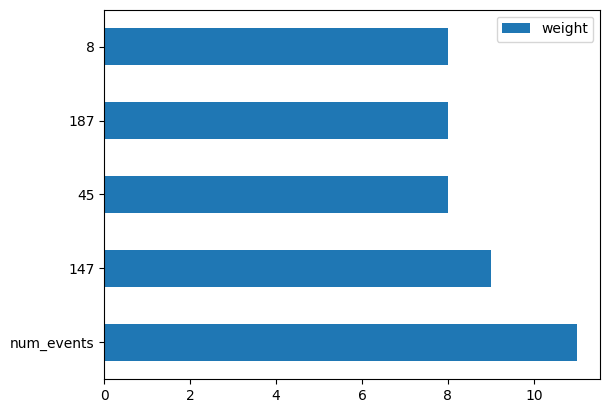

In [41]:
# show most important features
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=['weight']).sort_values(by='weight', ascending=False)
data.nlargest(5, columns='weight').plot(kind='barh')

It looks like the number of device events is the best indicator of a recall.

In [36]:
# save model and encoders to pickle
with open('xgboost/classifier.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('xgboost/pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('xgboost/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('xgboost/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

## regular logreg example


In [57]:
start = time.time()
model = LogisticRegression() 
model.fit(X_train.values, y_train)
print(f'----------- LinearRegression runtime: {time.time() - start} seconds -----------')

----------- LinearRegression runtime: 0.10777735710144043 seconds -----------


In [59]:
# predict on test set
predictions = model.predict(X_test.values)
accuracy = accuracy_score(y_test.values, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 91.44%


In [61]:
# emulate getting "score" of recall aka probability recall happens
import random
random_sample = random.randint(0, len(X_test)-1) 
score = model.predict_proba(X_test.iloc[[random_sample]].values)[0]
print(f'probability of device {random_sample} having recall: {float(score[1]) * 100}%')

probability of device 111 having recall: 90.52380233093173%


np.float64(0.03727014935250105)

<Axes: >

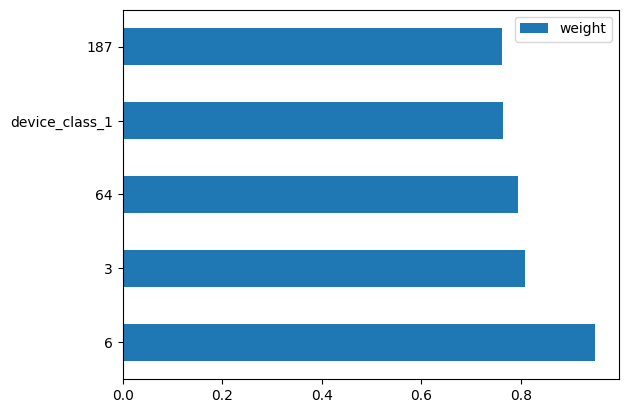

In [70]:
# show most important features
keys = [c for c in X_train.columns]
values = list( model.coef_[0])

data = pd.DataFrame(data=values, index=keys, columns=['weight']).sort_values(by='weight', ascending=False)
data.nlargest(5, columns='weight').plot(kind='barh')

In [72]:
# save model and encoders to pickle
with open('logreg/classifier.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('logreg/pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('logreg/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('logreg/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

### Notes

In [ ]:
# use pyspark
# use colab to train full model 
# in UI:
### have search for device name
### do fuzzy search in table --> create function
### collect and preprocess data for model
### output likelihood of recall

## TODO - create func to preprocess incoming input.

## TODO - create streamlist page to test model or integrate with Will's

In [ ]:
## QUERY to get matches on exact device names
# select count(*) from device d 
# join device_classification c on c.device_name = d.openfda_device_name 
# left join (select openfda_device_name, count(*) num_recalls from recall group by openfda_device_name) r on r.openfda_device_name = c.device_name;